# How To Use FB Prophet for Time-series Forecasting: Vehicle Traffic Volume


Recently, I came across a few articles mentioning Facebook's Prophet libaray that looked interesting (although the initial release is almost 3 years ago!), so I decided to dig more into it this weekend.

Prophet is an open source library developed by Facebook which aims to make time-series forecasting easy and scalable. It is a type of a generalized additive model (GAM), which uses regression model with potentially non-linear smoothers. It is called additive because it addes multiple decomposed parts to explain some trends. For example, Prophet uses the following components: 

$$ y(t) = g(t) + s(t) + h(t) + e(t) $$

where,  
$g(t)$: Growth. Big trend. Non-periodic changes.   
$s(t)$: Sesonality. Periodic changes (e.g. weekly, yearly, etc.) represented by Fourier Series.  
$h(t)$: Holiday effect that represents irregular schedules.   
$e(t)$: Error. Any idiosyncratic changes not explained by the model. 

In this post, I will explore basic concepts and main API endpoints of the Prophet library.

# Table of Contents 
1. [Prepare Data](#prep)
2. [Train And Predict](#train)
3. [Check Components](#components)
4. [Evaluate](#eval)
5. [Trend Change Points](#trend)
6. [Seasonality Mode](#season)
7. [Saving Model](#save)
8. [Summary](#summary)
9. [References](#ref)

<a id=prep></a>
# 1. Prepare Data

Let's prepare the data we will use in this tutorial. This U.S. traffic volumn data set is available for download [here](https://fred.stlouisfed.org/series/TRFVOLUSM227NFWA). It is monthly traffic volumn (miles traveled) on public roadways collected by state highway agencies. The data is from January 1970 until September 2020. The unit is millions miles. 

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse

# prophet functionalities we will explore
from fbprophet import Prophet 
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics 
from fbprophet.serialize import model_to_json, model_from_json


# to mute Pandas warnings Prophet needs to fix
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('../data/vehicle_miles_traveled.csv')
df.head()

,DATE,TRFVOLUSM227NFWA
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0


Prophet is hard-coded to use sepcific column names; `ds` for dates and `y` for the target variable we want to predict.

In [3]:
# Prophet requires column names to be 'ds' and 'y', and 'ds' needs to be datetime object. 
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])

When plotting the original data, we can see there is a **big, growing trend** in the traffic volumn, although there seems to be some stagnant or even decreasing trends (**change of rate**) around 1980, 2008 due to the subprime mortage crisis, and most strikingly, 2020 due to the COVID recession. Checking how Prophet can handle and adapt to these changes would be interesting.

Another thing that catches my eyes is that there is a **seasonal, periodic trend** that seems to repeat in each year. It goes up until middle of the year and goes down again. Will Prophet capture this as well?

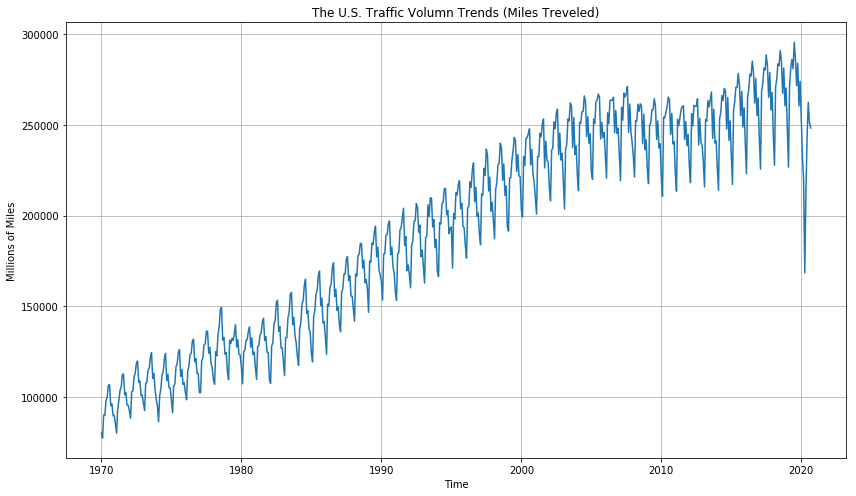

In [4]:
# plot raw data 
fig, ax = plt.subplots(figsize=(12, 7))
plt.plot(df['ds'], df['y'])
plt.xlabel('Time')
plt.ylabel('Millions of Miles')
plt.title('The U.S. Traffic Volumn Trends (Miles Treveled)')
plt.grid(True)
plt.tight_layout()
plt.show()

For train test split, do not forget that we cannot do a random split for time-series data. We use ONLY the earlier part of data for training and the later parts of data for testing given a cut-off point. Here, let's use 2019/1/1 as our cut-off point. 

In [5]:
# split data 
train = df[df['ds'] < pd.Timestamp('2019-01-01')]
test = df[df['ds'] >= pd.Timestamp('2019-01-01')]

In [6]:
print(f"Number of months in train data: {len(train)}")
print(f"Number of months in test data: {len(test)}")

Number of months in train data: 588
Number of months in test data: 21


<a id=train></a>
# 2. Train And Predict

Let's train a Prophet model. It's actually pretty simple. You just initialize an object and `fit`! That's all.

Prophet warns that it disabled weekly and daily seasonaility. That's fine because our data set is monthly and does not have more granular interval to capture weekly or daily seasonality.

In [7]:
# fit model - ignore train/test split for now 
m = Prophet()
m.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


When making predictions with Prophet, we need to prepare a special object called future dataframe. It is a Pandas DataFrame with a single column `ds` that includes all datetime within the training data plus additional periods given by user. 

The parameter `periods` is basically the number of points (rows) to predict after the end of the training data. The interval (parameter `freq`) is set to 'D' (day) by default, so we need to adjust it to 'MS' (month start) as our data is monthly. I set `periods=21` as it is the number points in the test data.

In [8]:
# future dataframe - placeholder object
future = m.make_future_dataframe(periods=21, freq='MS')  # one period = one row = 1 month with freq='MS'

In [9]:
# start of the future df is same as the original data 
future.head()

,ds
0,1970-01-01
1,1970-02-01
2,1970-03-01
3,1970-04-01
4,1970-05-01


In [10]:
# end of the future df is original + 21 periods (21 months)
future.tail()

,ds
604,2020-05-01
605,2020-06-01
606,2020-07-01
607,2020-08-01
608,2020-09-01


It's time to make actual predictions. It's simple - just `predict` with the placeholder DataFrame `future`. 

In [11]:
# predict the future
forecast = m.predict(future)

Prophet has a nice built-in plotting function to visualize forecast data. Black dots are for actual data and blue lines are prediction. You can also use matplotlib functions to adjust the figure, such as adding legend or adding xlim or ylim.

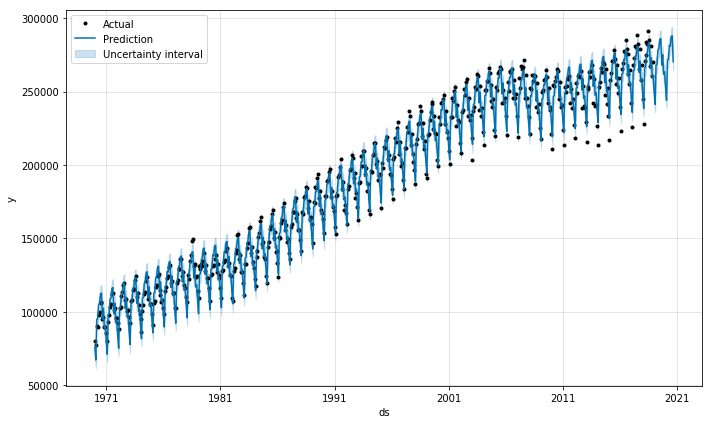

In [12]:
# Prophet's own plotting tool to see 
fig = m.plot(forecast)
plt.legend(['Actual', 'Prediction', 'Uncertainty interval'])
plt.show()

<a id=components></a>
# 3. Check Components

So, what is in our forecast data? Let's take a look.

In [13]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1970-01-01,94281.848744,70368.397606,80838.696661,94281.848744,94281.848744,-18700.514310,-18700.514310,-18700.514310,-18700.514310,-18700.514310,-18700.514310,0.0,0.0,0.0,75581.334434
1,1970-02-01,94590.609819,61305.448083,72814.535587,94590.609819,94590.609819,-27382.307301,-27382.307301,-27382.307301,-27382.307301,-27382.307301,-27382.307301,0.0,0.0,0.0,67208.302517
2,1970-03-01,94869.490789,89470.298853,100320.261990,94869.490789,94869.490789,37.306077,37.306077,37.306077,37.306077,37.306077,37.306077,0.0,0.0,0.0,94906.796867
3,1970-04-01,95178.251864,89978.116886,100639.000757,95178.251864,95178.251864,166.278079,166.278079,166.278079,166.278079,166.278079,166.278079,0.0,0.0,0.0,95344.529943
4,1970-05-01,95477.052904,99770.099904,110627.052135,95477.052904,95477.052904,9672.619044,9672.619044,9672.619044,9672.619044,9672.619044,9672.619044,0.0,0.0,0.0,105149.671948


There are many components in it but the main thing that you would care about is `yhat` which has the final predictions. `_lower` and `_upper` flags are for uncertainty intervals. 

- Final predictions: `yhat`, `yhat_lower`, and `yhat_upper`

Other columns are components that comprise the final prediction as we discussed in the introduction. Let's compare Prophet's additive components and what we see in our forecast DataFrame. 

$$y(t) = g(t) + s(t) + h(t) + e(t) $$

- Growth ($g(t)$): `trend`, `trend_lower`, and `trend_upper`
- Sesonality ($s(t)$): `additive_terms`, `additive_terms_lower`, and `additive_terms_upper`
    - Yearly seasonality: `yearly`, `yearly_lower`, and`yearly_upper`

The `additive_terms` represent the total seasonality effect, which is the same as yearly seasonality as we disabled weekly and daily seasonalities. All `multiplicative_terms` are zero because we used additive seasonality mode by default instead of multiplicative seasonality mode, which I will explain later.

Holiday effect ($h(t)$) is also not represented here as it's hourly data and we did not specify holidays for this data.

Prophet also has a nice built-in function for plotting each component. When we plot our forecast data, we see two components; general growth trend and yearly seasonality that appears throughout the years. 

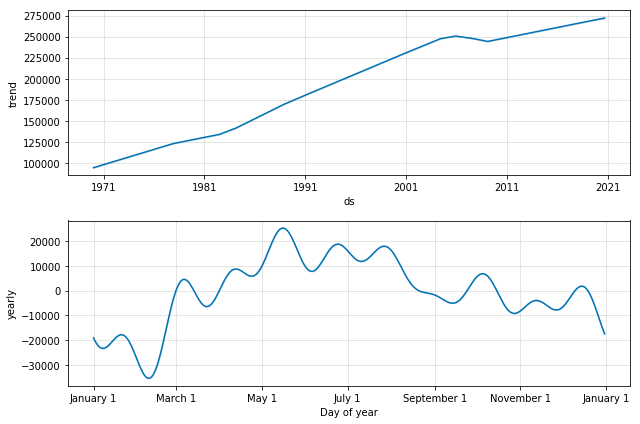

In [14]:
# plot components
fig = m.plot_components(forecast)

<a id="eval"></a>
# 4. Evaluate 

## 4.1. Evaluate the model on one test set

So, how good is our model? One way we can understand the model performance in this case is to simply calculate the root mean squared error (RMSE) between the actual and predicted values of the above test period.

In [15]:
predictions = forecast.iloc[-len(test):]['yhat']
actuals = test['y']

print(f"RMSE: {round(rmse(predictions, actuals))}")

RMSE: 32969.0


However, this probably under-represents the general model performance because our data has a drastic change in the middle of test period which is a pattern that has never been seen before. If our data was until 2019, the model performance score would have been much higher. 

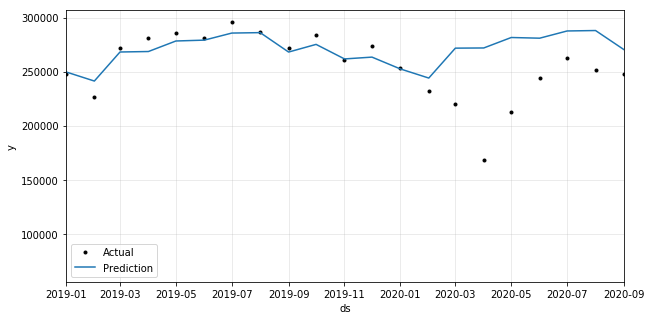

In [16]:
# visually compare actual and predictions
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(test['ds'], test['y'],  'k.', label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Prediction')
ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2020-09-01'))
ax.set_xlabel('ds')
ax.set_ylabel('y')
ax.legend()
plt.grid(True, alpha=0.3)

## 4.2. Cross validation

Alternatively, we can perform cross validation. As previously discussed, time-series analysis strictly uses train data whose time range is always earlier than that of test data. Below is an example where we use 5 years of train data to predict 1 year of test data. Each cut-off point is equally spaced with 1 year gap.


<div style="text-align:center">
<img src='images/prophet_cv.png' alt="cv"/>
<figcaption>How cross validation works
</figcaption>
</div>
<br>

Prophet also provides built-in model diagnostics tools to make it easy to perform this cross validation. You just need to define three parameters: horizon, initial, and period. The latter two are optional. 

Make sure to define these parameters in straing and in this format: 'X unit'. X is the number and unit is 'days' or 'secs', etc. that is compatiable with `pd.Timedelta`.

In [17]:
# horizon = test period of each fold
horizon = '365 days'

# initial: training period. (optional. default is 3x of horizon)
initial = str(365 * 5) + ' days'  

# period: spacing between cutoff dates (optional. default is 0.5x of horizon)
period = str(365 * 5) + ' days' 

df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon)

INFO:fbprophet:Making 9 forecasts with cutoffs between 1977-12-11 00:00:00 and 2017-12-01 00:00:00


This is the predicted output using cross validation. When there are many predictions for the same timestamp due to overlapping test periods is case of `period` shorter than `horizon`, Prophet will use the ones predicted using the latest data.

In [18]:
# predicted output using cross validation
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1978-01-01,112522.812909,110831.321969,114259.361748,109838.0,1977-12-11
1,1978-02-01,108452.772239,106887.507738,109969.465946,107018.0,1977-12-11
2,1978-03-01,122874.816391,121224.886200,124454.819781,125035.0,1977-12-11
3,1978-04-01,125277.537316,123839.260408,126936.650540,122741.0,1977-12-11
4,1978-05-01,132901.373944,131296.364309,134563.414729,134427.0,1977-12-11
...,...,...,...,...,...,...
103,2018-08-01,279835.003826,274243.776401,285813.313435,284989.0,2017-12-01
104,2018-09-01,261911.246557,255930.691785,267698.203888,267434.0,2017-12-01
105,2018-10-01,268979.448383,263094.641355,274372.557820,281382.0,2017-12-01
106,2018-11-01,255612.520483,250018.692730,261475.834516,260473.0,2017-12-01


Below is different performance metrics for different rolling windows. As we did not define any rolling window, Prophet went ahead and calculated many different combinations and stacked up in rows. Each metrics are first calculated within each rolling window and then averaged across many available windows. 

In [19]:
# performance metrics  
df_metrics = performance_metrics(df_cv)  # can define window size, e.g. rolling_window=365
df_metrics

,horizon,mse,rmse,mae,mape,mdape,coverage
0,52 days,1.413842e+07,3760.109582,2773.156701,0.015467,0.013055,0.7
1,53 days,1.496116e+07,3867.965318,2897.556266,0.016536,0.013055,0.7
2,54 days,1.500784e+07,3873.994934,2912.627049,0.016448,0.013055,0.7
3,56 days,1.927735e+07,4390.597783,3539.567300,0.020282,0.016455,0.6
4,57 days,2.162156e+07,4649.898458,3793.406605,0.021477,0.021856,0.5
...,...,...,...,...,...,...,...
94,360 days,3.613908e+07,6011.578982,3680.343858,0.016739,0.014002,0.7
95,361 days,3.609567e+07,6007.967590,3635.370589,0.016512,0.014002,0.7
96,363 days,4.954110e+07,7038.543584,4410.052273,0.019648,0.014002,0.7
97,364 days,2.121658e+07,4606.145466,2771.955964,0.012717,0.006670,0.8


<a id="trend"></a>
# 5. Trend Change Points

Another interesting functionality of `Prophet` is `add_changepoints_to_plot`. As we discussed in the earlier sections, there are a couple of points where the growth rate changes. Prophet can find those points automatically and plot them!

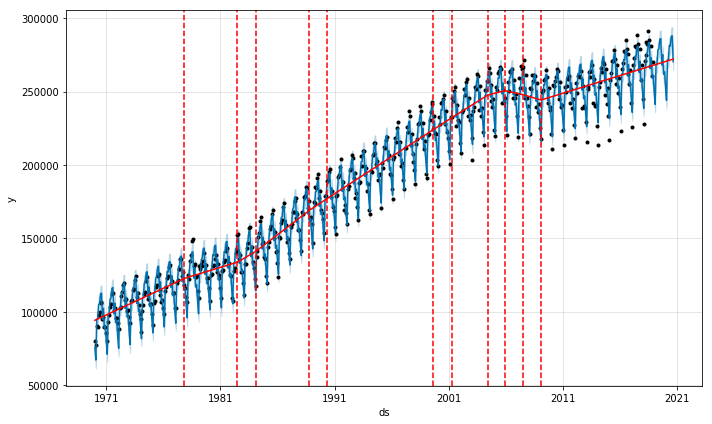

In [20]:
# plot change points
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

<a id=season></a>
# 6. Seasonality Mode

The growth in trend can be additive (rate of change is linear) or multiplicative (rate changes over time). When you see the original data below, the amplitude of seasonality of the data is changing - smaller in the early years and bigger in the later years. So, this would be `multiplicative` growth case rather than `additive` growth case. We can adjust the `seasonality` parameter so we can take into account this effect. 

Text(0.5, 1.0, 'Additive seasonality')

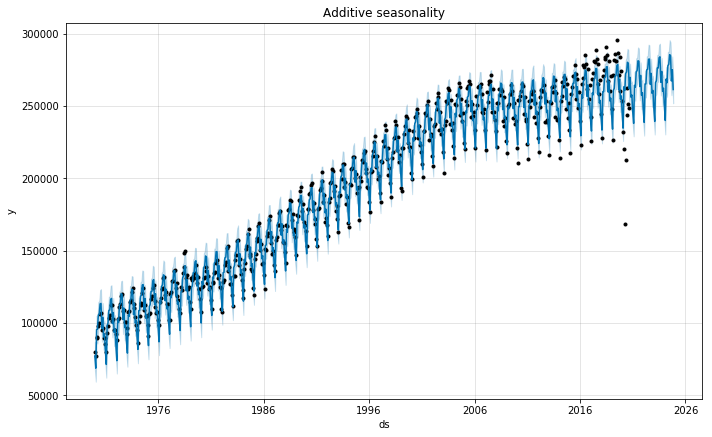

In [21]:
# additive mode
m = Prophet(seasonality_mode='additive', weekly_seasonality=False, daily_seasonality=False)
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)
plt.title('Additive seasonality')

Text(0.5, 1.0, 'Multiplicative seasonality')

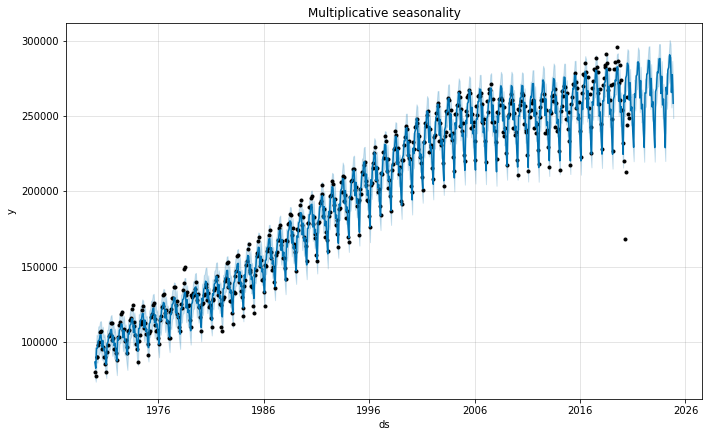

In [22]:
# multiplicative mode
m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)
plt.title('Multiplicative seasonality')

<a id=save></a>
# 7. Saving Model

We can also easily export and load the trained model as json.

In [23]:
# Save model
with open('serialized_model.json', 'w') as fout:
    json.dump(model_to_json(m), fout)

# Load model
with open('serialized_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  

<a id=summary></a>
# 8. Summary 

Here are some summary code for Prophet's basic functionalities. We did not explore adding regressors but it will come soon!

#### Training and prediction
* Note: Input df columns should be: 'ds' and 'y'

```python
# fit
m = Prophet()
m.fit(df)

# make prediction
future = m.make_future_dataframe(periods=24, freq='MS')  # period = each row 
forecast = m.predict(future)  # inlcudes train + predicted horizon  
```

#### Ploting the forecast and components 
```
# plot actual + prediction
m.plot(forecast)

# plot trends and seasonalities
m.plot_components(forecast) 
```  

#### Cross validation

```python
df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon)
df_metrics = performance_metrics(df_cv)
```


#### Checking inflection points 
```python
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
```


#### Additive vs. Multiplicative seasonality
```python
# seasonality will be added to the trend
m = Prophet(seasonality_mode='additive')

# seasonality will multiply the trend
m = Prophet(seasonality_mode='multiplicative')
```

<a id=ref></a>
# 9. References

- [Prophet documentation](https://facebook.github.io/prophet/docs/quick_start.html#python-api)
- [Prophet GitHub repository](https://github.com/facebook/prophet)
- [Prophet paper: Forecasting at scale](https://peerj.com/preprints/3190/)
- [Prophet in R](https://cran.r-project.org/web/packages/prophet/prophet.pdf)
- [U.S. traffic volume data](https://fred.stlouisfed.org/series/TRFVOLUSM227NFWA)
- [Python for Time Series Data Analysis](https://www.udemy.com/course/python-for-time-series-data-analysis/)